In [39]:
import os
%run funciones.py
import json
import pandas as pd
import numpy as np
from funciones import *
from keras.models import load_model

In [40]:
pruebas = pd.read_csv("..\data\pruebas.csv")

stop = list(pruebas['name stops'])
real = list(pruebas['real'])
link = list(zip(pruebas['ini_stop'], pruebas['end_stop']))
time = list(zip(pruebas['hora'], pruebas['minuto']))
step = list(pruebas['step'])

c = ['Nro','Stops','Link', 'Time', 'Real', 'Sum_Set', 'err_mean_set', 'input_set', 'err_input_set', 'input_concat', 'err_input_concat', 'model', 'step']
preds = pd.DataFrame(columns=c)

for file in os.listdir('../models/'):
    model_path = f'../models//{file}'
    json_path = f'../info_models/{file[:-2]}json'

    # cargar archivos
    info_model = json.load(open(json_path))
    model = load_model(model_path, compile=False)

    # ingresar parametros
    div_split = info_model['div_split']
    input_out_length = (info_model['INPUT_LENGTH'], info_model['OUTPUT_LENGTH'])  
    SCALER = info_model['scaler']
    CONV = info_model['isCONV']
    range_links = tuple(info_model['range_links'])
    path_dataset = "../data/"+info_model['name_dataset']
    input_shape = (1, ) + model.input_shape[1:]
    print(f"{file}")
    print(f"Parametros de prediccion: {div_split}, {input_out_length}, {SCALER}, CONV:{CONV}, {range_links}, {path_dataset}, {input_shape}")

    # leer dataset
    cols = ['id_linkref', 'horas', 'minute', 'travel_time']
    origin_dataset = pd.read_csv(path_dataset, sep=',', usecols=cols)
    dataset = origin_dataset[cols]

    # delimitar links
    if range_links != (0, 82):
        dataset =  dataset[(dataset['id_linkref']>= range_links[0]) & (dataset['id_linkref']<=range_links[1])]
    print(f"Links del dataset desde {range_links[0]} - {range_links[1]} = {len(dataset['id_linkref'].unique())} links")

    # preparar dataset para la prediccion segun el modelo
    data, scaler = cargar_dataset(dataset, div_split, input_out_length, SCALER, CONV)

    dt_input = data['ts'].reset_index()
    for i in range(len(real)):
        # encontrar input: retorna indices de los samples que coniden como input
        res = find_input(dt_input, stop=link[i][0], time=time[i], input_size=input_out_length[0])

        # escoger un indice aleatorio para pa prediccion
        #if len(res)==0:
        #    print(f'sample {i} sin input coincidente')
        #    continue
        if len(res)==0:
            print(link[0], time[i])
            break
        tmp = np.random.choice(len(res))

        # predecir el tiempo de viaje
        mean, y_of_set, y_of_pred = predict_travel_time(
            n_links = link[i][1] - link[i][0],
            shape_input= input_shape,
            id_sample= res[tmp],
            data_in_s= data['x_ts_s'],
            data_in = data['x_ts'],
            modelo = model,
            scaler=scaler,
            conv=CONV
        )

        # calcular tiempo de viaje, suma de todas las predicciones en cada link
        p_mean = round(sum(mean),0) # promedio, para verificar en que se basa las predicciones
        p_set = round(sum(y_of_set), 0) # usamos input un grupo de muestras del dataset test
        p_concat = round(sum(y_of_pred), 0) # concadenamos las predicciones al siguiente input

        # calcular el error de cada forma de prediccion
        err_p_mean = real[i] - p_mean
        err_p_set = real[i] - p_set
        err_p_concat = real[i] - p_concat 

        # agregar al df pred
        preds.loc[len(preds)] = [i+1, stop[i], link[i], time[i], real[i], p_mean, err_p_mean, p_set, err_p_set, p_concat, err_p_concat, file[:-3], step[i]]

    print('=> Pruebas Completadas')
    print('='*120)

BASE-Conv2DLSTM_e200b256_Maxmin_in83-4_dt0-82.h5
Parametros de prediccion: 83, (83, 1), Maxmin, CONV:True, (0, 82), ../data/travel_time_series.csv, (1, 83, 4, 1, 1)
Links del dataset desde 0 - 82 = 83 links
1/1 [==============================] - 0s 442ms/step
=> Pruebas Completadas
BASE-Conv2DLSTM_e200b256_Robust_in83-4_dt0-82.h5
Parametros de prediccion: 83, (83, 1), Robust, CONV:True, (0, 82), ../data/travel_time_series.csv, (1, 83, 4, 1, 1)
Links del dataset desde 0 - 82 = 83 links
1/1 [==============================] - 0s 336ms/step
=> Pruebas Completadas
BASE-Conv2DLSTM_e200b256_Standar_in83-4_dt0-82.h5
Parametros de prediccion: 83, (83, 1), Standar, CONV:True, (0, 82), ../data/travel_time_series.csv, (1, 83, 4, 1, 1)
Links del dataset desde 0 - 82 = 83 links
1/1 [==============================] - 0s 323ms/step
=> Pruebas Completadas
BASE-LSTM_e200b256_Maxmin_in83-4_dt0-82.h5
Parametros de prediccion: 83, (83, 1), Maxmin, CONV:False, (0, 82), ../data/travel_time_series.csv, (1, 83

In [41]:
print(preds.to_string())

     Nro                                           Stops      Link      Time    Real  Sum_Set  err_mean_set  input_set  err_input_set  input_concat  err_input_concat                                              model  step
0      1                             Puente Grau - Belén  (55, 56)  (12, 45)   221.0    190.0          31.0      167.0           54.0         167.0              54.0      BASE-Conv2DLSTM_e200b256_Maxmin_in83-4_dt0-82     1
1      2   Hospital regional - Puerta Universidad UNSAAC  (45, 46)   (9, 30)    94.0    112.0         -18.0       99.0           -5.0          99.0              -5.0      BASE-Conv2DLSTM_e200b256_Maxmin_in83-4_dt0-82     1
2      3                   Teléfono - Universidad Andina  (21, 22)    (9, 0)    24.0     48.0         -24.0       44.0          -20.0          44.0             -20.0      BASE-Conv2DLSTM_e200b256_Maxmin_in83-4_dt0-82     1
3      4            Colegio Garcilaso - Colegio Clorinda  (49, 50)   (9, 30)   142.0     24.0         118.0 

In [42]:
def RMSE_MAE_MAPE_seconds(Real_vec, Pred_vec):
    vector_real = Real_vec
    vector_predicho = Pred_vec

    # Calcular las métricas RSME - MSE - MAE
    rmse = np.sqrt(mean_squared_error(vector_real, vector_predicho))
    mae = mean_absolute_error(vector_real, vector_predicho)
    mape = mean_absolute_percentage_error(vector_real, vector_predicho)

    # Calcular el RMSE
    return rmse, mae, mape

In [45]:
res_models = pd.DataFrame(columns=['model', 'rmse', 'mae', 'mape'])
for model, df in preds.groupby('model'):
    df = df[df['step'] == 1]
    rmse, mae, mape = RMSE_MAE_MAPE_seconds(df['Real'], df['input_concat'])
    res_models.loc[len(res_models)] = [model, rmse, mae, mape]

In [46]:
res_models.sort_values(by='rmse')

,model,rmse,mae,mape
11,ENC-DEC-LSTM_e200b256_Standar_in83-4_dt0-82,24.101452,18.36,0.333430
6,ENC-DEC-Conv2DLSTM_e200b256_Maxmin_in83-4_dt0-82,25.139212,19.22,0.338567
2,BASE-Conv2DLSTM_e200b256_Standar_in83-4_dt0-82,25.444449,19.54,0.344390
7,ENC-DEC-Conv2DLSTM_e200b256_Robust_in83-4_dt0-82,25.535074,19.84,0.350889
1,BASE-Conv2DLSTM_e200b256_Robust_in83-4_dt0-82,25.545645,19.22,0.321793
4,BASE-LSTM_e200b256_Robust_in83-4_dt0-82,26.016149,19.04,0.349696
5,BASE-LSTM_e200b256_Standar_in83-4_dt0-82,26.613155,19.06,0.331631
0,BASE-Conv2DLSTM_e200b256_Maxmin_in83-4_dt0-82,26.947356,20.68,0.363327
8,ENC-DEC-Conv2DLSTM_e200b256_Standar_in83-4_dt0-82,27.627161,19.54,0.322961
10,ENC-DEC-LSTM_e200b256_Robust_in83-4_dt0-82,28.968949,21.24,0.355147


In [7]:
total_err_input_set = {}
total_err_input_concat = {}
for mod in preds['model'].unique():
    df_tmp = preds[preds['model'] == mod]
    total_err_input_set[mod] = abs(df_tmp['err_input_set']).sum()
    total_err_input_concat[mod] = abs(df_tmp['err_input_concat']).sum()

In [8]:
from operator import itemgetter
dict(sorted(total_err_input_set.items(), key=itemgetter(1)))

{'ENC-DEC-LSTM_e200b256_Standar_in83-4_dt0-82': 781.0,
 'BASE-Conv2DLSTM_e200b256_Standar_in83-4_dt0-82': 801.0,
 'ENC-DEC-Conv2DLSTM_e200b256_Maxmin_in83-4_dt0-82': 809.0,
 'ENC-DEC-Conv2DLSTM_e200b256_Robust_in83-4_dt0-82': 832.0,
 'BASE-Conv2DLSTM_e200b256_Robust_in83-4_dt0-82': 850.0,
 'ENC-DEC-Conv2DLSTM_e200b256_Standar_in83-4_dt0-82': 867.0,
 'BASE-Conv2DLSTM_e200b256_Maxmin_in83-4_dt0-82': 875.0,
 'ENC-DEC-LSTM_e200b256_Robust_in83-4_dt0-82': 882.0,
 'BASE-LSTM_e200b256_Standar_in83-4_dt0-82': 891.0,
 'BASE-LSTM_e200b256_Robust_in83-4_dt0-82': 953.0,
 'ENC-DEC-LSTM_e200b256_Maxmin_in83-4_dt0-82': 67061.0,
 'BASE-LSTM_e200b256_Maxmin_in83-4_dt0-82': 73312.0}

In [9]:
from operator import itemgetter
dict(sorted(total_err_input_concat.items(), key=itemgetter(1)))

{'ENC-DEC-LSTM_e200b256_Robust_in83-4_dt0-82': 777.0,
 'ENC-DEC-LSTM_e200b256_Standar_in83-4_dt0-82': 792.0,
 'BASE-Conv2DLSTM_e200b256_Standar_in83-4_dt0-82': 802.0,
 'ENC-DEC-Conv2DLSTM_e200b256_Maxmin_in83-4_dt0-82': 809.0,
 'ENC-DEC-Conv2DLSTM_e200b256_Robust_in83-4_dt0-82': 831.0,
 'BASE-Conv2DLSTM_e200b256_Robust_in83-4_dt0-82': 850.0,
 'ENC-DEC-Conv2DLSTM_e200b256_Standar_in83-4_dt0-82': 865.0,
 'BASE-Conv2DLSTM_e200b256_Maxmin_in83-4_dt0-82': 875.0,
 'BASE-LSTM_e200b256_Standar_in83-4_dt0-82': 886.0,
 'BASE-LSTM_e200b256_Robust_in83-4_dt0-82': 895.0,
 'BASE-LSTM_e200b256_Maxmin_in83-4_dt0-82': 61369.0,
 'ENC-DEC-LSTM_e200b256_Maxmin_in83-4_dt0-82': 67409.0}

In [17]:
# leer dataset busstop
busstopdf = pd.read_csv('../data/busstops_ida.csv')

# diseño del df: creacion de latitude_longitude
busstopdf['latitude_longitude'] = busstopdf.apply(lambda row: (row['latitude'], row['longitude']), axis=1)
busstopdf.drop(columns=['number', 'latitude', 'longitude'], inplace=True)

# para fines practicos modificamos el id = index para mejor lectura
busstopdf['id'] = [f'{i+100}' for i in busstopdf.index]

# creamos dataframe links y renombramos columnas
tmp1 = busstopdf[['id','name']].head(busstopdf.shape[0]-1).reset_index(drop=True)
# tmp1.rename(columns={'id':'ini_id', 'name':'ini_name'}, inplace=True)
tmp1.rename(columns={'id':'init_stop', 'name':'init_name'}, inplace=True)

tmp2 = busstopdf[['id','name']].tail(busstopdf.shape[0]-1).reset_index(drop=True)
# tmp2.rename(columns={'id':'end_id', 'name':'end_name'}, inplace=True)
tmp2.rename(columns={'id':'end_stop', 'name':'end_name'}, inplace=True)
linksdf = pd.concat([tmp1, tmp2], axis=1)

# creamos la columnas link
# linksdf['link'] = linksdf.apply(lambda row: f"{row['ini_id']}:{row['end_id']}", axis=1)
linksdf['link'] = linksdf.apply(lambda row: f"{row['init_stop']}:{row['end_stop']}", axis=1)
linksdf['id_link'] = linksdf.index
linksdf.insert(0, 'id_link', linksdf.pop('id_link'))
print(linksdf.to_string())

    id_link init_stop                  init_name end_stop                   end_name     link
0         0       100                     inicio      101                primer stop  100:101
1         1       101                primer stop      102               segundo stop  101:102
2         2       102               segundo stop      103                   Ccollana  102:103
3         3       103                   Ccollana      104            Puente Huaccoto  103:104
4         4       104            Puente Huaccoto      105                      Kayra  104:105
5         5       105                      Kayra      106                   Forestal  105:106
6         6       106                   Forestal      107                Grifo Tapia  106:107
7         7       107                Grifo Tapia      108                      Posta  107:108
8         8       108                      Posta      109                  Romeritos  108:109
9         9       109                  Romeritos      110   

Mostrar graficas de entrenamiento y mejora de rmse por epocas

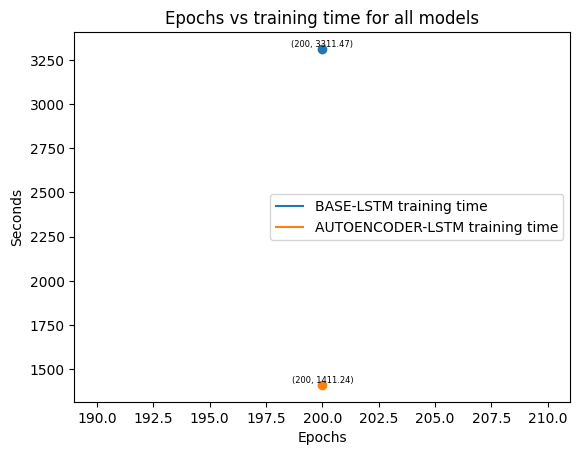

In [18]:
# Definir la ruta de la carpeta que contiene los archivos JSON
ruta_carpeta = '../info_models/'
name_models = ['BASE-LSTM','AUTOENCODER-LSTM','BASE-Conv2DLSTM','AUTOENCODER-Conv2DLSTM']

# Inicializar una lista para almacenar los DataFrames de cada archivo JSON
dataframes = []

# Recorrer los archivos en la carpeta
for archivo in os.listdir(ruta_carpeta):
    if archivo.endswith('.json'):
        # Leer el archivo JSON y cargarlo en un DataFrame
        ruta_archivo = os.path.join(ruta_carpeta, archivo)
        df = pd.read_json(ruta_archivo, lines=True)
        
        # Agregar el DataFrame a la lista
        dataframes.append(df)

# Combinar los DataFrames en uno solo
data = pd.concat(dataframes, ignore_index=True)

# # Mostrar el DataFrame resultante
for k in range(len(name_models)-2):
    
    data_temp = data[data['n_modelo'] == name_models[k]].sort_values('epoch').reset_index()

    # Plotear las columnas Columna1 y Columna2
    plt.scatter(data_temp['epoch'], data_temp['training_time'])
    plt.plot(data_temp['epoch'], data_temp['training_time'], label = str(data_temp['n_modelo'][0] + ' training time'))

    for x, y in zip(data_temp['epoch'], data_temp['training_time']):
        plt.text(x, y, f"({int(x)}, {round(y,2)})", ha='center', va='bottom', fontsize=6)
    plt.xlabel('Epochs')
    plt.ylabel('Seconds')
    plt.title('Epochs vs training time for all models')

    # Mostrar el gráfico
plt.legend()   
plt.show()

In [19]:
from datetime import datetime

def calcular_diferencia_fechas(fecha_hora1, fecha_hora2):
    formato = "%Y-%m-%d %H:%M:%S"  # Formato de las fechas y horas
    try:
        fecha_hora1 = datetime.strptime(fecha_hora1, formato)
        fecha_hora2 = datetime.strptime(fecha_hora2, formato)
        diferencia = fecha_hora1 - fecha_hora2
        diferencia_segundos = diferencia.total_seconds()
        return abs(diferencia_segundos)  # Valor absoluto para obtener la diferencia positiva
    except ValueError:
        return None

# Ejemplo de uso
fecha_hora1 = "2023-07-06 09:20:59"
fecha_hora2 = "2023-07-06 09:20:05"
diferencia = calcular_diferencia_fechas(fecha_hora1, fecha_hora2)
if diferencia is not None:
    print(f"La diferencia en segundos es: {diferencia}")
else:
    print("Error: formato de fecha y hora incorrecto")

La diferencia en segundos es: 54.0
